## Import necessary packages tutorial

In [1]:
import renom as rm
from renom.utility.initializer import GlorotNormal, GlorotUniform
import gym

/Users/thakur/ReNom/renom/cuda/__init__.py:12: UserWarning: Couldn't find cuda modules. No module named 'renom.cuda.cuda_base'
  warnings.warn("Couldn't find cuda modules. %s" % e)
/Users/thakur/ReNom/renom/cuda/__init__.py:29: UserWarning: Couldn't find cuda modules.
  warnings.warn("Couldn't find cuda modules.")


## Deifne the environment tutorial

In [2]:
env = gym.make('Pendulum-v0')

[2018-03-16 17:40:30,373] Making new env: Pendulum-v0


## Define the actor network tutorial

In [3]:
class Actor(rm.Model):
    
    '''Here considered 3-layer network (excluding input layer). Feel free to change the network depth 
    and check the results. The output-layer number of nuerons are equal to number of actions.
    In the example of OpenAI Gym's Pendlum-v0 environment number of actions are 1.'''
    
    def __init__(self, env, layer_size):
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(self.env.action_space.shape[0], initializer=GlorotUniform())
        self._layers = [self._l1, self._l2, self._l3]
    
    def forward(self, x):
        '''Neural Network inputs are state information, outputs are actions. '''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(h1))
        h3 = rm.tanh(self._l3(h2)) 
        #h = self._l3(h2)
        h = h3*self.env.action_space.high[0]
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay


# Define the Critic network tutorial

In [4]:
class Critic(rm.Model):
    '''Here considered a 3-layer network (input layer, hidden layer-1, hidden layer-2, output layer)
        At input-layer state information, 2nd-hidden layer actions are applied, last layer has a single neuron'''
    def __init__(self, env, layer_size):        
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(1, initializer=GlorotUniform())
        self._layers = [self._l1, self._l2, self._l3]
  
    def forward(self, x, action):
        '''Q(s,a) calculation for a given (state, action) pair'''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(rm.concat(h1,action))) # actions are applied at 2nd hidden layer
        h = self._l3(h2)        
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay

## Instantiating the actor & ciritic networks 

In [5]:
from renom.algorithm.reinforcement.ddpg import DDPG
layer_size = [400, 300] # two-hidden layers dimension
actor_network = Actor(env=env,layer_size=layer_size)
critic_network = Critic(env=env, layer_size=layer_size)
target_actor_network = Actor(env=env,layer_size=layer_size)
target_critic_network = Critic(env=env, layer_size=layer_size)

## Instantiating the DDPG class

In [6]:
ddpg = DDPG(env=env, actor_network=actor_network, critic_network=critic_network, \
            target_actor_network=target_actor_network, target_critic_network=target_critic_network)
# ddpg = DDPG(env=env) # for default

## Training 

In [7]:
[reward_list, loss_list]=ddpg.train(num_episodes=300)

episode: 000 Total reward:-1390.50 avg loss:3.3639: 100%|██████████| 200/200 [00:04<00:00, 44.20it/s]
episode: 001 Total reward:-1416.37 avg loss:1.6378: 100%|██████████| 200/200 [00:06<00:00, 33.24it/s]
episode: 002 Total reward:-1493.51 avg loss:0.5620: 100%|██████████| 200/200 [00:05<00:00, 35.14it/s]
episode: 003 Total reward:-1487.45 avg loss:0.3463: 100%|██████████| 200/200 [00:06<00:00, 32.91it/s]
episode: 004 Total reward:-1380.03 avg loss:0.3079: 100%|██████████| 200/200 [00:05<00:00, 33.74it/s]
episode: 005 Total reward:-1293.05 avg loss:0.2533: 100%|██████████| 200/200 [00:05<00:00, 35.40it/s]
episode: 006 Total reward:-1537.07 avg loss:0.2491: 100%|██████████| 200/200 [00:05<00:00, 33.86it/s]
episode: 007 Total reward:-1499.96 avg loss:0.2381: 100%|██████████| 200/200 [00:05<00:00, 34.10it/s]
episode: 008 Total reward:-1639.76 avg loss:0.2179: 100%|██████████| 200/200 [00:05<00:00, 34.80it/s]
episode: 009 Total reward:-941.10 avg loss:0.2520: 100%|██████████| 200/200 [00:05

episode: 080 Total reward:-1645.20 avg loss:37.6414: 100%|██████████| 200/200 [00:06<00:00, 30.13it/s]
episode: 081 Total reward:-1493.83 avg loss:35.7666: 100%|██████████| 200/200 [00:05<00:00, 38.07it/s]
episode: 082 Total reward:-1656.26 avg loss:31.8822: 100%|██████████| 200/200 [00:05<00:00, 37.50it/s]
episode: 083 Total reward:-1075.70 avg loss:35.9736: 100%|██████████| 200/200 [00:05<00:00, 37.80it/s]
episode: 084 Total reward:-1174.02 avg loss:41.6436: 100%|██████████| 200/200 [00:05<00:00, 34.72it/s]
episode: 085 Total reward:-1390.88 avg loss:44.4567: 100%|██████████| 200/200 [00:05<00:00, 38.19it/s]
episode: 086 Total reward:-1148.84 avg loss:37.7789: 100%|██████████| 200/200 [00:05<00:00, 37.67it/s]
episode: 087 Total reward:-1497.79 avg loss:29.6179: 100%|██████████| 200/200 [00:05<00:00, 37.69it/s]
episode: 088 Total reward:-1343.20 avg loss:42.4411: 100%|██████████| 200/200 [00:05<00:00, 35.34it/s]
episode: 089 Total reward:-1368.76 avg loss:34.5062: 100%|██████████| 200

episode: 159 Total reward:-1323.94 avg loss:65.3709: 100%|██████████| 200/200 [00:06<00:00, 31.86it/s]
episode: 160 Total reward:-1179.96 avg loss:73.5786: 100%|██████████| 200/200 [00:05<00:00, 33.74it/s]
episode: 161 Total reward:-1296.53 avg loss:50.3788: 100%|██████████| 200/200 [00:06<00:00, 32.14it/s]
episode: 162 Total reward:-1208.92 avg loss:55.3549: 100%|██████████| 200/200 [00:06<00:00, 29.61it/s]
episode: 163 Total reward:-398.93 avg loss:60.2574: 100%|██████████| 200/200 [00:05<00:00, 34.40it/s]
episode: 164 Total reward:-270.27 avg loss:72.1277: 100%|██████████| 200/200 [00:05<00:00, 34.53it/s]
episode: 165 Total reward:-1124.80 avg loss:59.9640: 100%|██████████| 200/200 [00:05<00:00, 33.80it/s]
episode: 166 Total reward:-138.22 avg loss:69.0461: 100%|██████████| 200/200 [00:05<00:00, 32.74it/s]
episode: 167 Total reward:-1182.23 avg loss:68.5150: 100%|██████████| 200/200 [00:06<00:00, 32.62it/s]
episode: 168 Total reward:-134.40 avg loss:72.2578: 100%|██████████| 200/200

episode: 239 Total reward:-1173.19 avg loss:101.8424: 100%|██████████| 200/200 [00:06<00:00, 34.58it/s]
episode: 240 Total reward:-136.61 avg loss:80.7692: 100%|██████████| 200/200 [00:07<00:00, 27.12it/s]
episode: 241 Total reward:-1093.97 avg loss:101.4220: 100%|██████████| 200/200 [00:05<00:00, 31.49it/s]
episode: 242 Total reward:-1519.06 avg loss:76.7636: 100%|██████████| 200/200 [00:05<00:00, 35.09it/s]
episode: 243 Total reward:-1268.78 avg loss:87.5917: 100%|██████████| 200/200 [00:05<00:00, 33.36it/s]
episode: 244 Total reward:-241.53 avg loss:75.0846: 100%|██████████| 200/200 [00:06<00:00, 32.43it/s]
episode: 245 Total reward:-948.17 avg loss:101.5172: 100%|██████████| 200/200 [00:06<00:00, 32.13it/s]
episode: 246 Total reward:-1292.09 avg loss:86.0632: 100%|██████████| 200/200 [00:05<00:00, 37.44it/s]
episode: 247 Total reward:-136.20 avg loss:101.2288: 100%|██████████| 200/200 [00:05<00:00, 38.11it/s]
episode: 248 Total reward:-1192.75 avg loss:85.8086: 100%|██████████| 200

## Testing

In [8]:
test_reward_list = ddpg.test(render=False,episodes=10)

episode: 009 Total reward:-122.05: 100%|██████████| 200/200 [00:00<00:00, 322.47it/s]    


## Plotting the test result

Text(0,0.5,'Total Rewards per Episode')

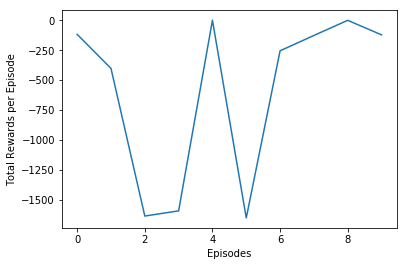

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards per Episode")